# scMIAC Tutorial

This tutorial demonstrates scMIAC (Single-Cell Multi-modality Integration via cell type filtered Anchors using Contrastive learning) for diagonal integration: integrating unpaired RNA-seq and ATAC-seq data.

**Workflow**: Data Loading → Anchor Finding → Preprocessing → Training → Inference → Visualization → Evaluation

## Step 1: Setup

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import torch

from scmiac import find_anchors, preprocess, train_model, model_inference, set_seed
from scmiac.preprocessing.preprocess import run_umap
from scmiac.evaluation.benchmark import ct_ASW, foscttm

sc.set_figure_params(figsize=(8, 6), dpi=80)
set_seed(seed=24)

## Step 2: Load Data

In [2]:
rna_file = "../data/10x/input/adata_rna_10x.h5ad"
atac_file = "../data/10x/input/adata_atac_10x.h5ad"

adata_rna = sc.read(rna_file)
adata_atac = sc.read(atac_file)

## Step 3: Find Cross-modal Anchors

Use MNN algorithm to find RNA-ATAC cell pairs of same cell type.

In [3]:
anchor_df = find_anchors(
    adata_rna,
    adata_atac,
    all_nfeatures=3000,
    single_nfeatures=2000,
    k_anchor=5,
    n_components=30,
    ct_filter=True,
    mode=None,
    rna_celltype_key='cell_type',
    atac_celltype_key='pred'
)

print(f"Found {len(anchor_df)} anchor pairs")

Number of common genes: 18353


Find anchors across datasets.
1. prepare input matrix for CCA
2. run cca between datasets
Run CCA


non zero dims 30
3. normalize CCV per sample/row
4. find MNN of U and V to find anchors
Find Anchors using k=30


5. filter anchors by high dimensional neighbors
6. score anchors with snn and local structure preservation


Number of anchor pairs: 18286
Number of anchors pairs after cell type filtering: 15639
Number of RNA anchors: 6979; Number of ATAC anchors: 6647
Found 15639 anchor pairs


In [4]:
anchor_df.head(10)

,x1,x2,score,x1_ct,x2_ct,is_same
0,0,254,0.48,CD4 Naive,CD4 Naive,True
3,0,6303,0.36,CD4 Naive,CD4 Naive,True
4,2,5147,0.64,CD4 Naive,CD4 Naive,True
5,2,0,0.56,CD4 Naive,CD4 Naive,True
6,2,10165,0.28,CD4 Naive,CD4 Naive,True
7,2,1347,0.68,CD4 Naive,CD4 Naive,True
8,2,4368,0.48,CD4 Naive,CD4 Naive,True
9,3,9596,1.00,CD8 Naive,CD8 Naive,True
10,3,8262,1.00,CD8 Naive,CD8 Naive,True
11,3,6854,0.92,CD8 Naive,CD8 Naive,True


## Step 4: Data Preprocessing

Initialize VAE models and create PyTorch data loaders.

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

rna_vae, atac_vae, all_cells_loader, anchor_cells_loader = preprocess(
    adata_rna,
    adata_atac,
    anchor_df,
    rna_latent_key='X_pca',
    atac_latent_key='lsi49',
    batch_size=256,
    hidden_dims=[128, 64],
    latent_dim=30,
    balanced_sampler=True,
    device=device
)

Device: cuda:0


## Step 5: Train Models

Train VAE models with contrastive learning on anchor pairs (100 epochs for demo, use 2000+ for production).

In [6]:
rna_vae, atac_vae = train_model(
    rna_vae,
    atac_vae,
    all_cells_loader,
    anchor_cells_loader,
    device=device,
    num_epoches=2000,
    lambda_rna_kl=1.0,
    lambda_atac_kl=1.0,
    alpha_rna_rec=20.0,
    alpha_atac_rec=20.0,
    lambda_contra=300.0,
    temperature=0.5,
    anchor_loss_type='contrastive',
    lr=1e-3,
    print_step=500
)

Epoch 0, Total: 1982.87, RNA Reco: 1000.88, RNA KLD: 0.52, ATAC Reco: 980.95, ATAC KLD: 0.52, Contra: 0.00


Epoch 500, Total: 1528.36, RNA Reco: 92.49, RNA KLD: 82.80, ATAC Reco: 72.30, ATAC KLD: 81.47, Contra: 1199.30


Epoch 1000, Total: 1515.50, RNA Reco: 89.55, RNA KLD: 82.66, ATAC Reco: 67.91, ATAC KLD: 81.95, Contra: 1193.44


Epoch 1500, Total: 1509.40, RNA Reco: 87.23, RNA KLD: 82.61, ATAC Reco: 66.60, ATAC KLD: 82.00, Contra: 1190.96


## Step 6: Generate Embeddings

Use trained encoders to map cells to shared latent space.

In [7]:
rna_embeddings, atac_embeddings = model_inference(
    rna_vae,
    atac_vae,
    all_cells_loader,
    device=device
)

print(f"RNA embeddings shape: {rna_embeddings.shape}")
print(f"ATAC embeddings shape: {atac_embeddings.shape}")

RNA embeddings shape: (10412, 30)
ATAC embeddings shape: (10412, 30)


## Step 7: Merge and Compute UMAP

In [8]:
adata_rna.obsm['scmiac_latent'] = rna_embeddings
adata_atac.obsm['scmiac_latent'] = atac_embeddings
adata_rna.obs['modality'] = 'RNA'
adata_atac.obs['modality'] = 'ATAC'

adata_cm = ad.concat([adata_rna, adata_atac], join='outer', index_unique=None)
adata_cm = run_umap(adata_cm, 'scmiac_latent')

/mnt/nfs_share/tlj/envs/scMIAC/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/mnt/nfs_share/tlj/envs/scMIAC/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


UMAP embedding is stored in adata.obsm['scmiac_latent_umap']


## Step 8: Visualization

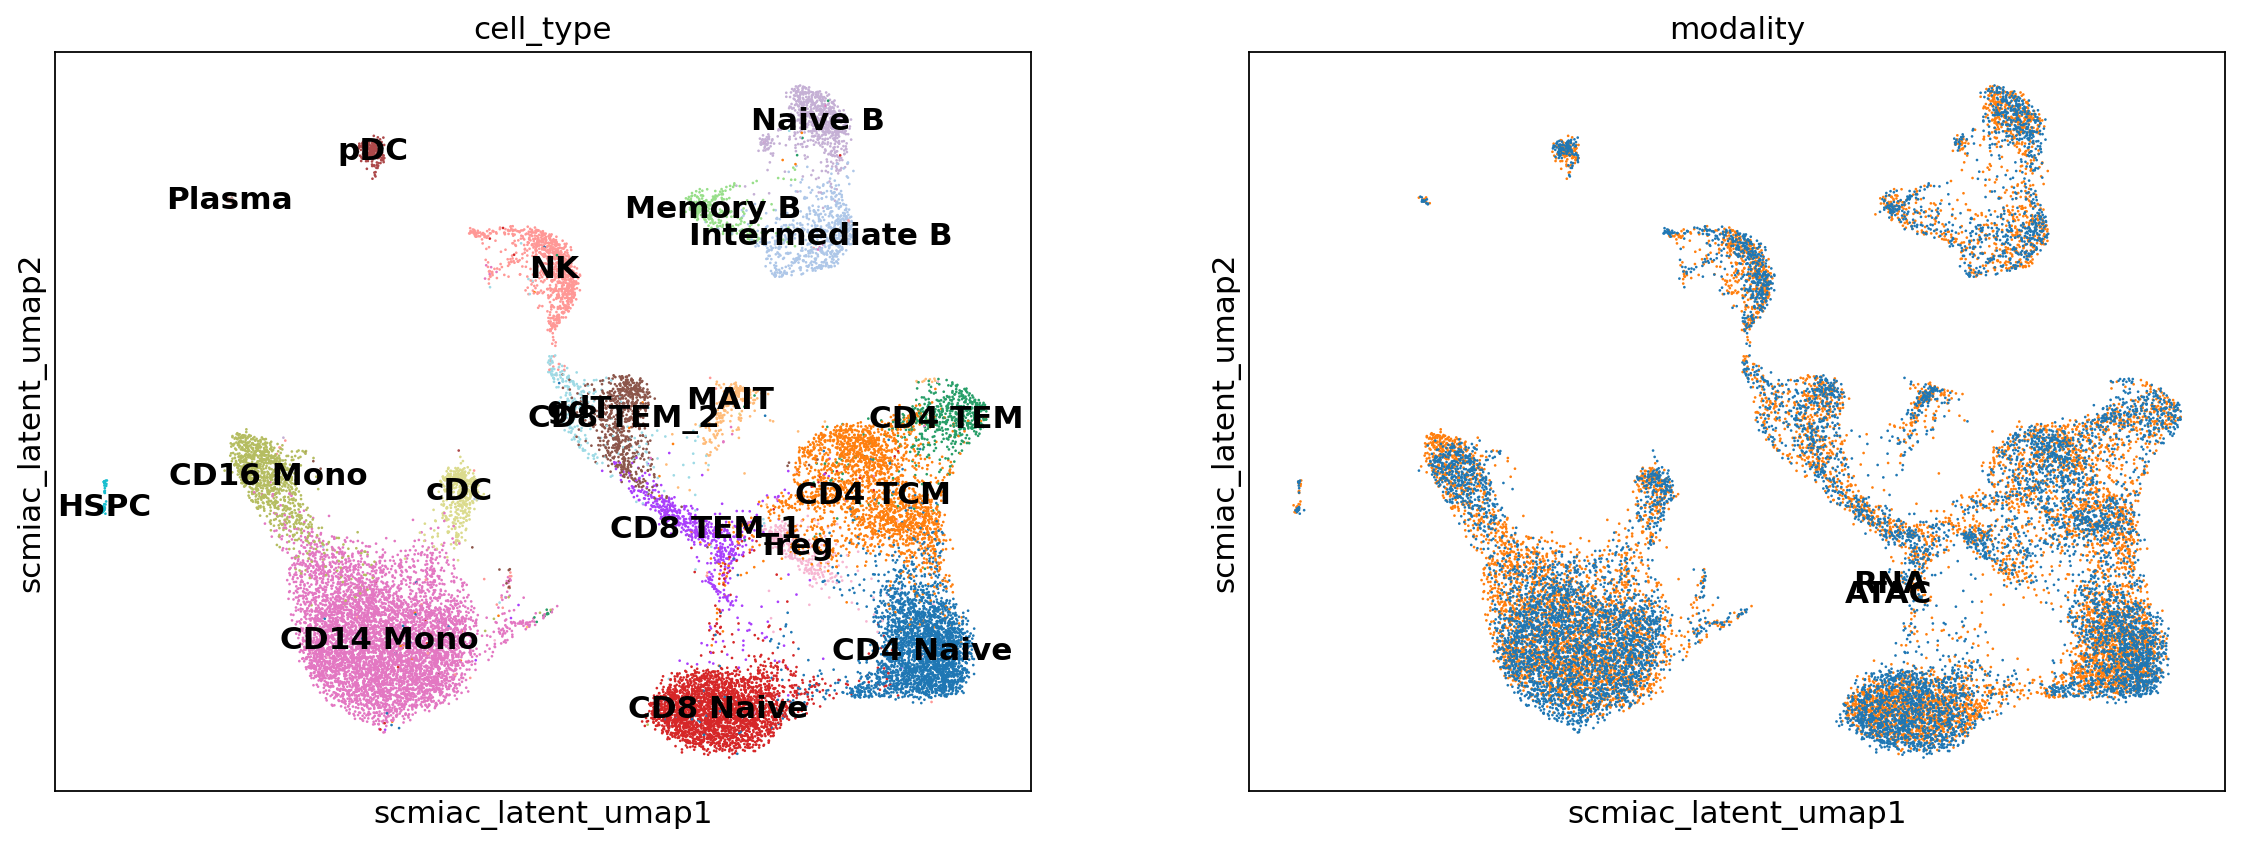

In [9]:
sc.pl.embedding(adata_cm, basis='scmiac_latent_umap', color=['cell_type','modality'], legend_loc='on data')

## Step 9: Integration Quality Assessment

In [10]:
ct_asw = ct_ASW(adata_cm.obsm['scmiac_latent'], adata_cm.obs['cell_type'].values)
print(f"Cell type ASW: {ct_asw:.4f}")

Cell type ASW: 0.6559


In [11]:
foscttm_result = foscttm(adata_rna.obsm['scmiac_latent'], adata_atac.obsm['scmiac_latent'])
foscttm_rna = np.mean(foscttm_result[0])
foscttm_atac = np.mean(foscttm_result[1])
foscttm = (foscttm_rna + foscttm_atac) / 2
print(f"RNA FOSCTTM: {foscttm_rna:.4f}, ATAC FOSCTTM: {foscttm_atac:.4f}, Average FOSCTTM: {foscttm:.4f}")

RNA FOSCTTM: 0.0307, ATAC FOSCTTM: 0.0316, Average FOSCTTM: 0.0312
